<Figure size 640x480 with 0 Axes>

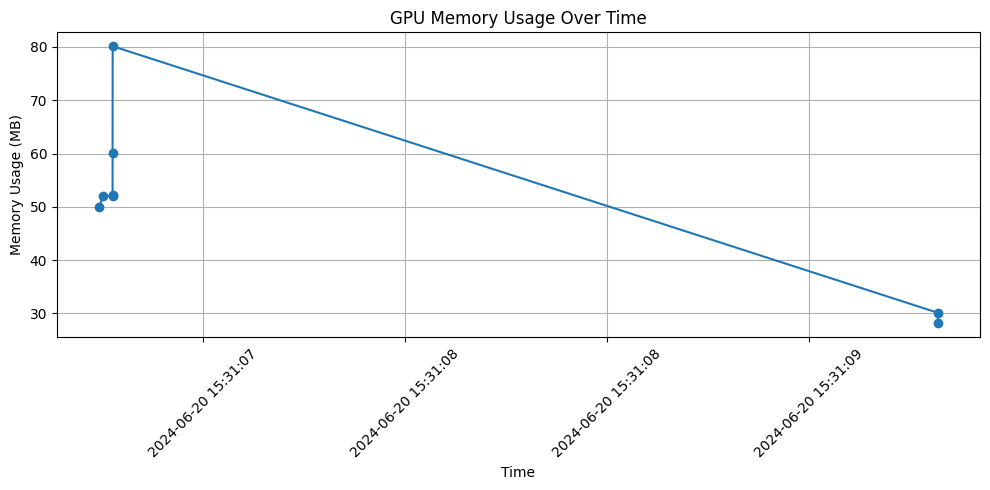

<Figure size 640x480 with 0 Axes>

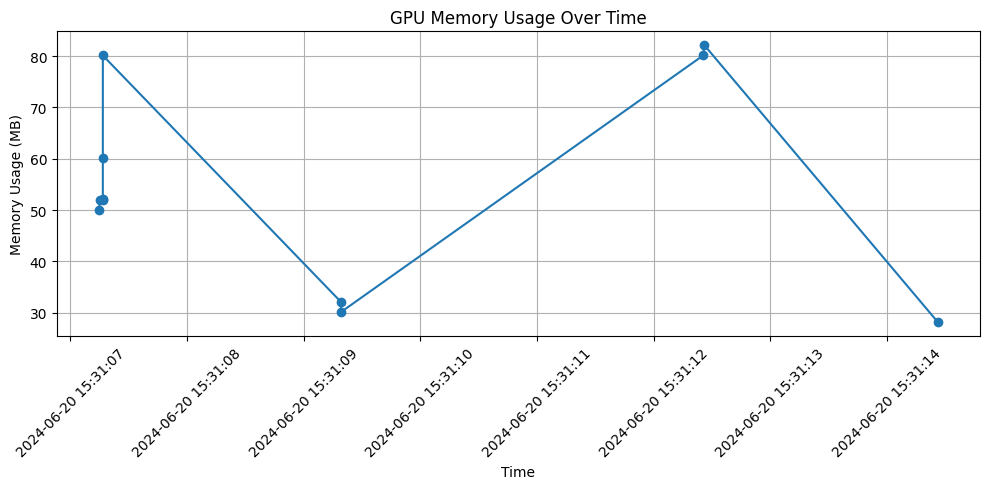

<Figure size 640x480 with 0 Axes>

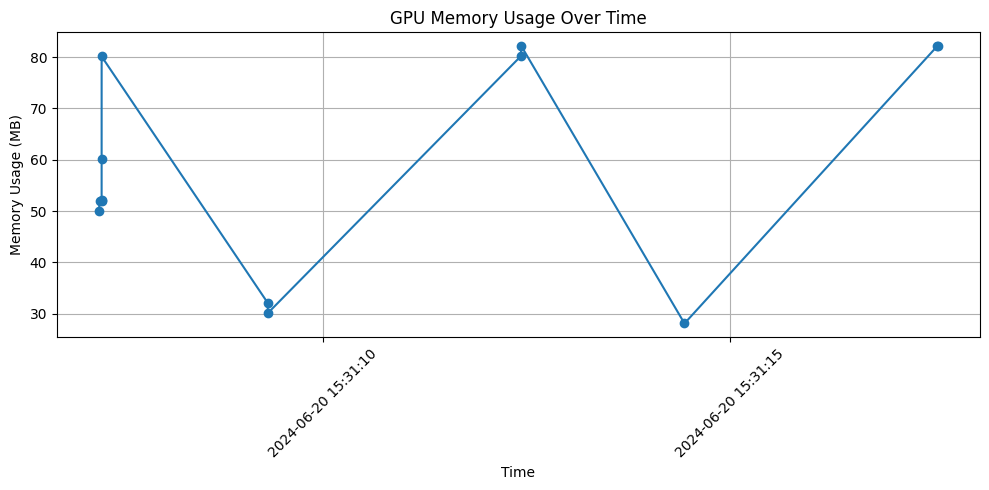

<Figure size 640x480 with 0 Axes>

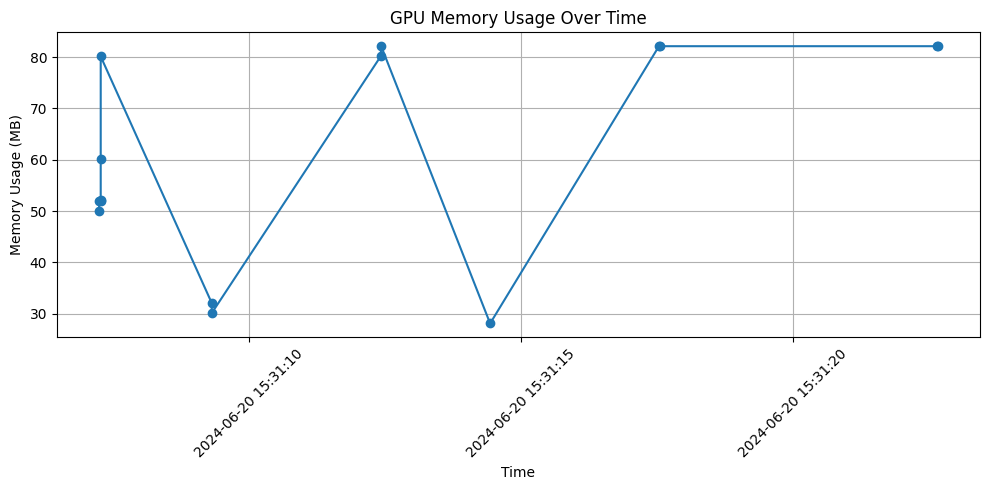

<Figure size 640x480 with 0 Axes>

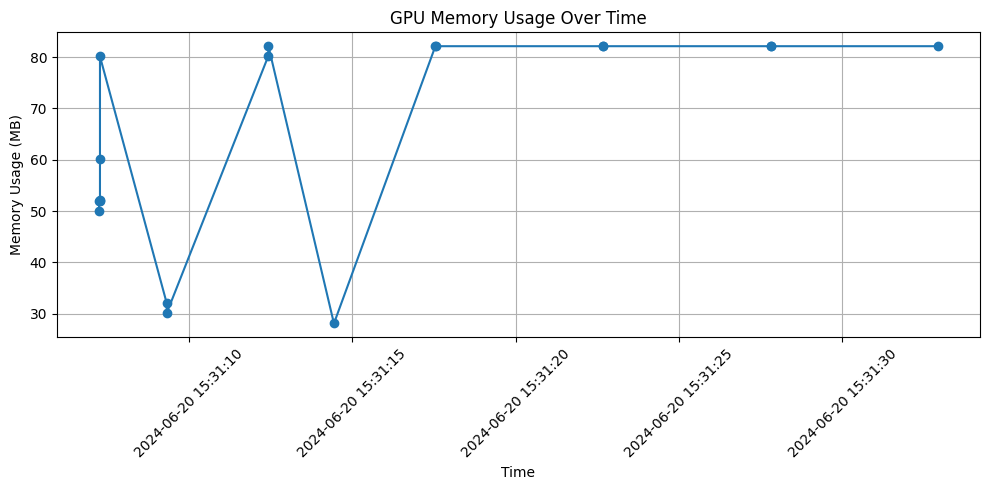

<Figure size 640x480 with 0 Axes>

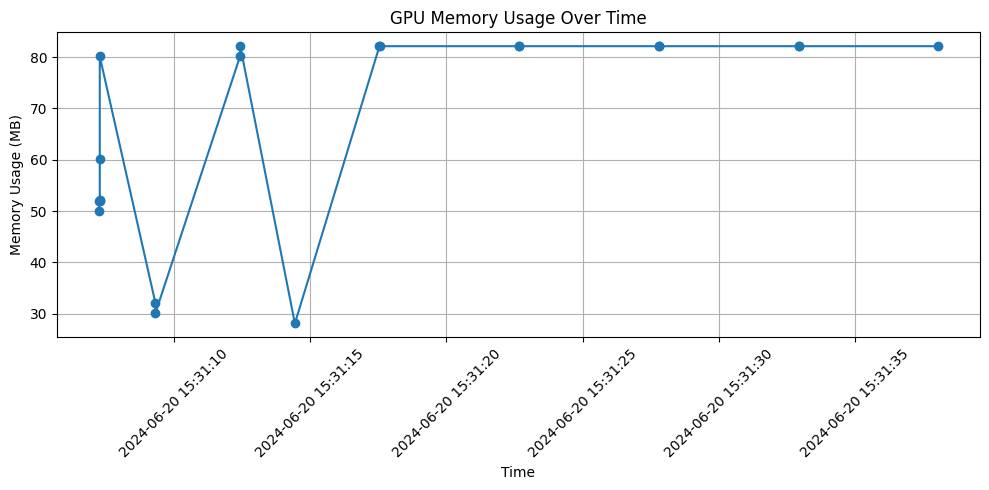

<Figure size 640x480 with 0 Axes>

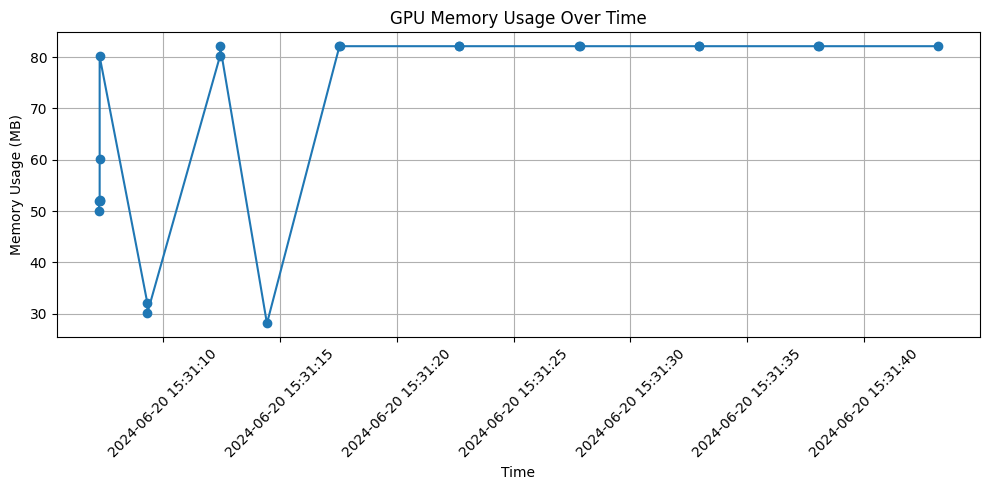

<Figure size 640x480 with 0 Axes>

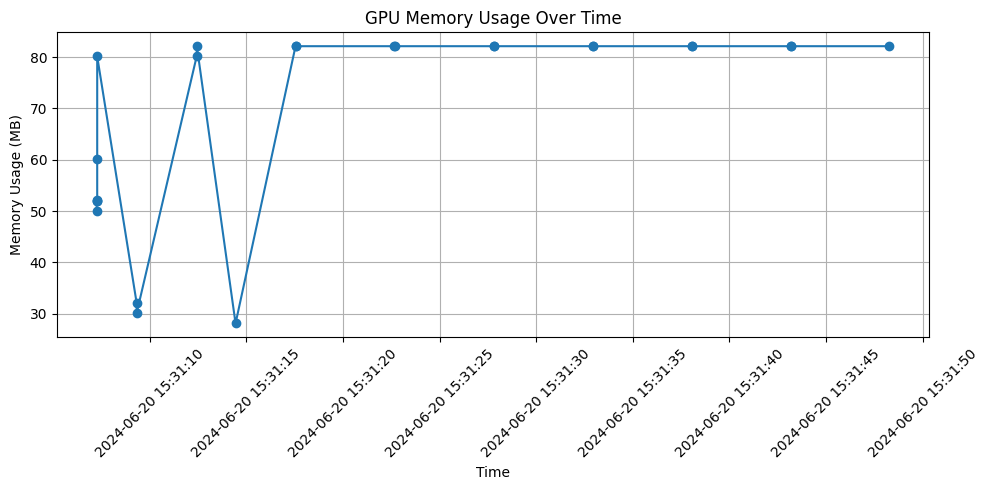

<Figure size 640x480 with 0 Axes>

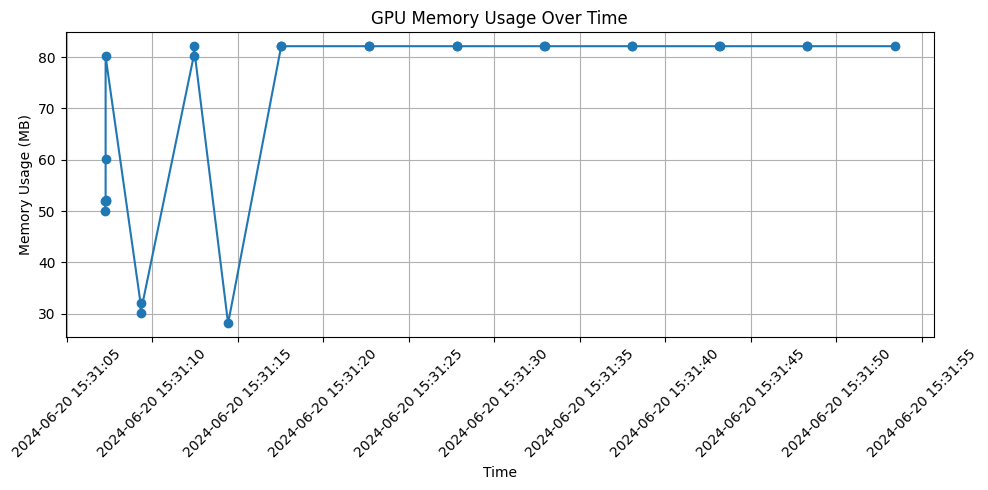

<Figure size 640x480 with 0 Axes>

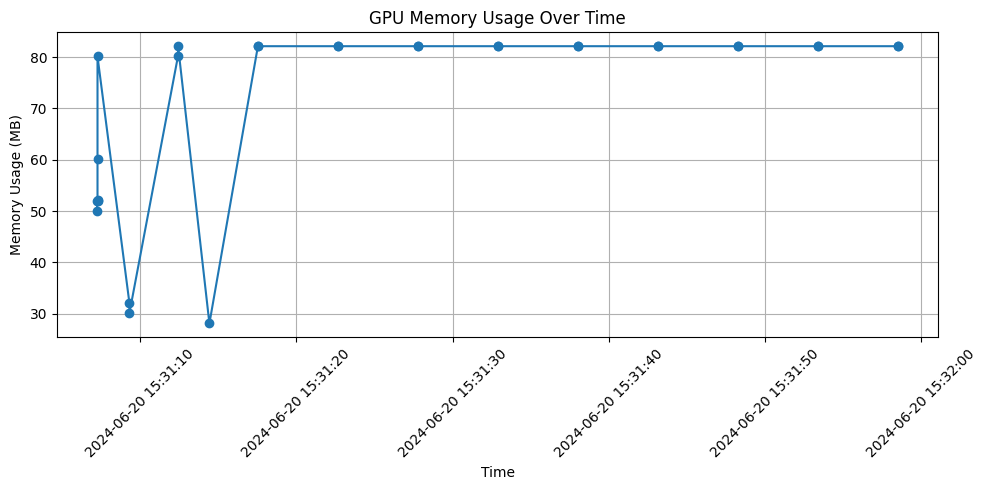

<Figure size 640x480 with 0 Axes>

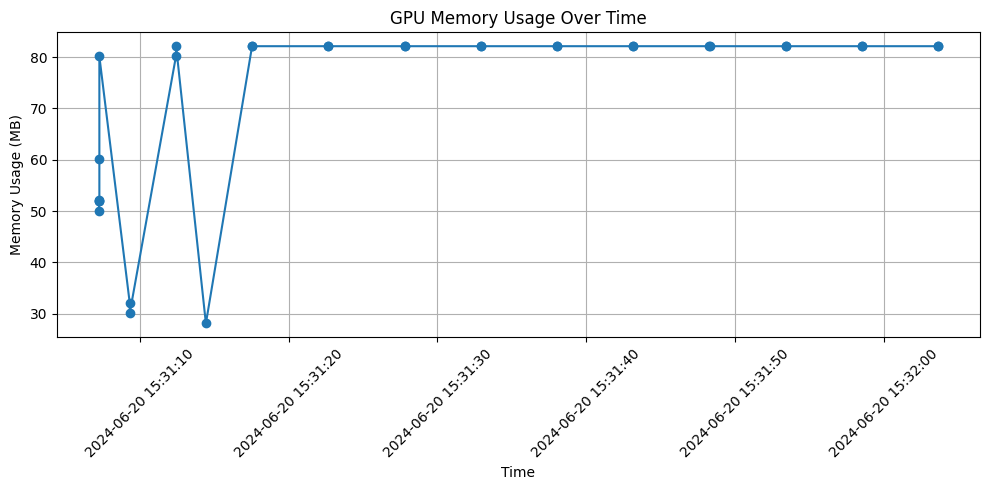

<Figure size 640x480 with 0 Axes>

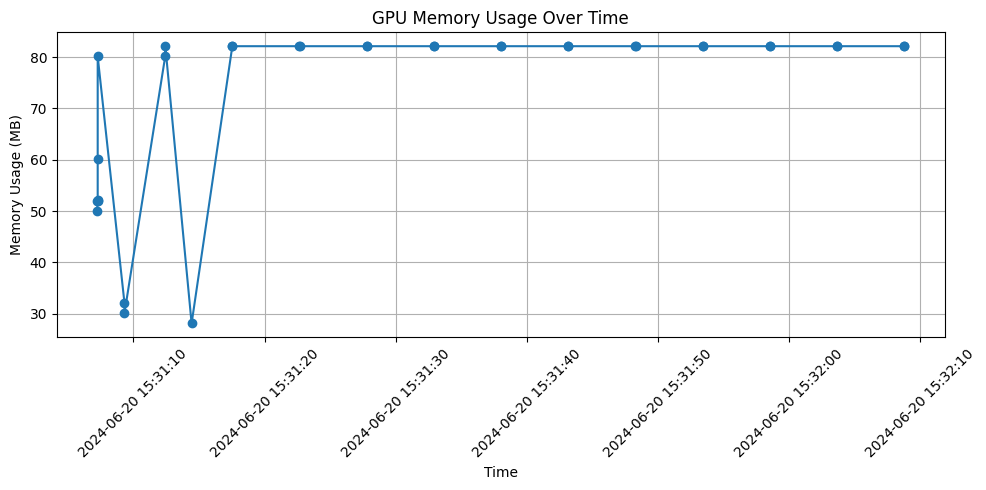

<Figure size 640x480 with 0 Axes>

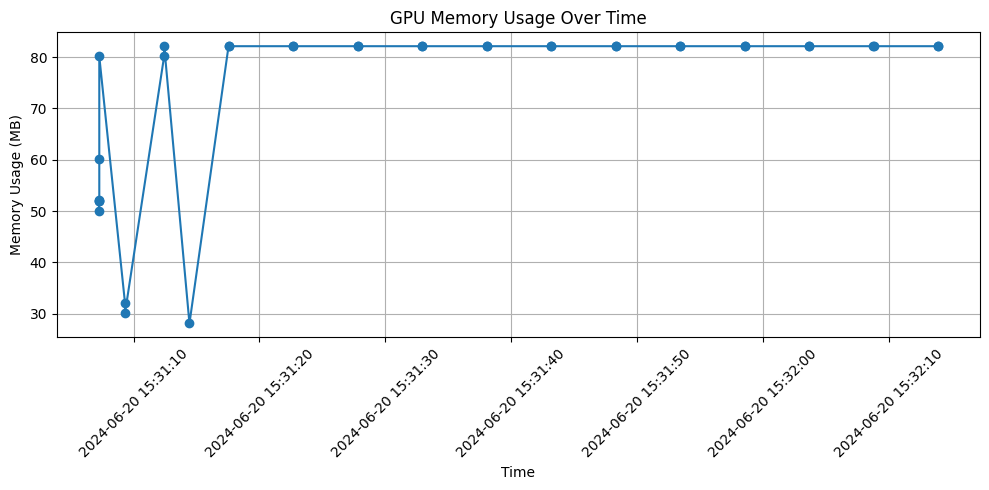

<Figure size 640x480 with 0 Axes>

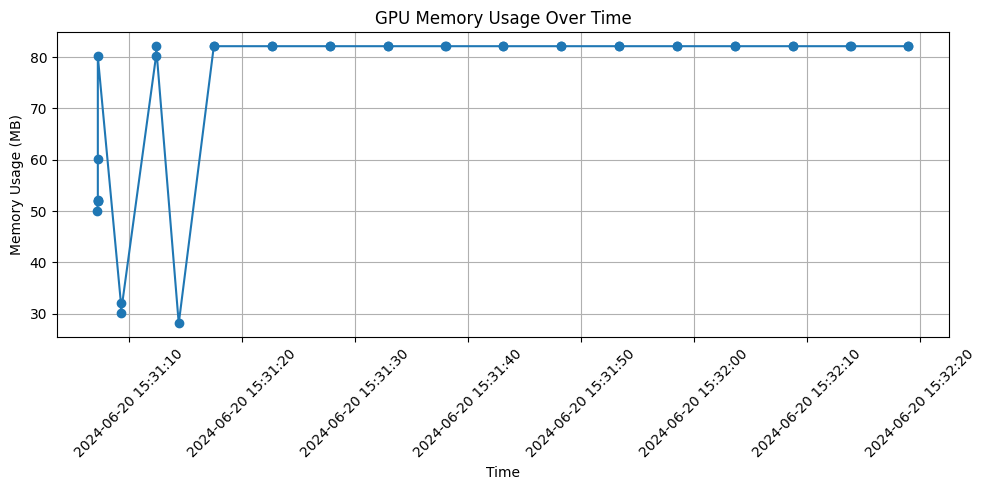

<Figure size 640x480 with 0 Axes>

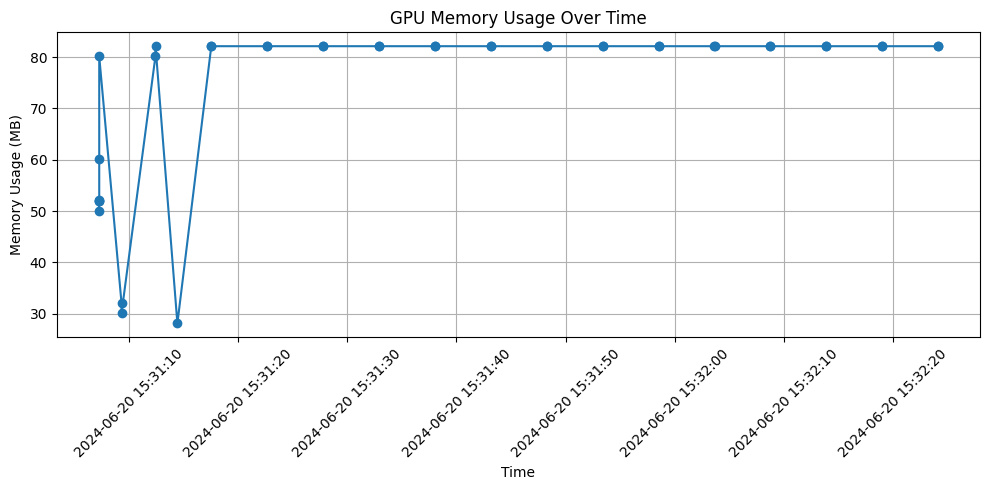

<Figure size 640x480 with 0 Axes>

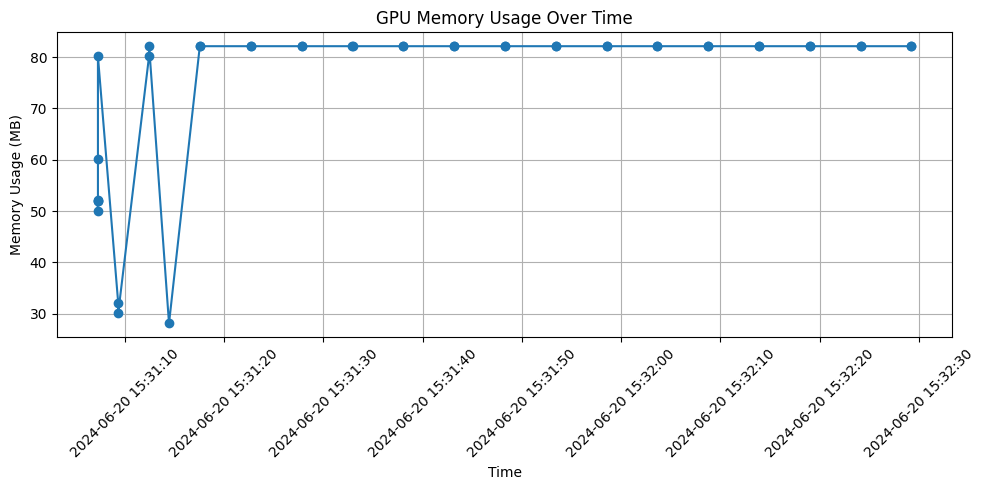

<Figure size 640x480 with 0 Axes>

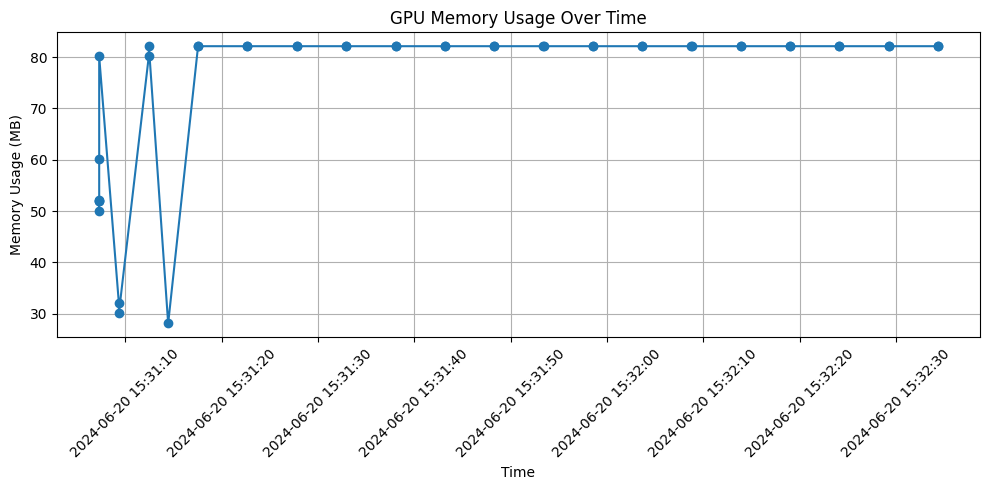

<Figure size 640x480 with 0 Axes>

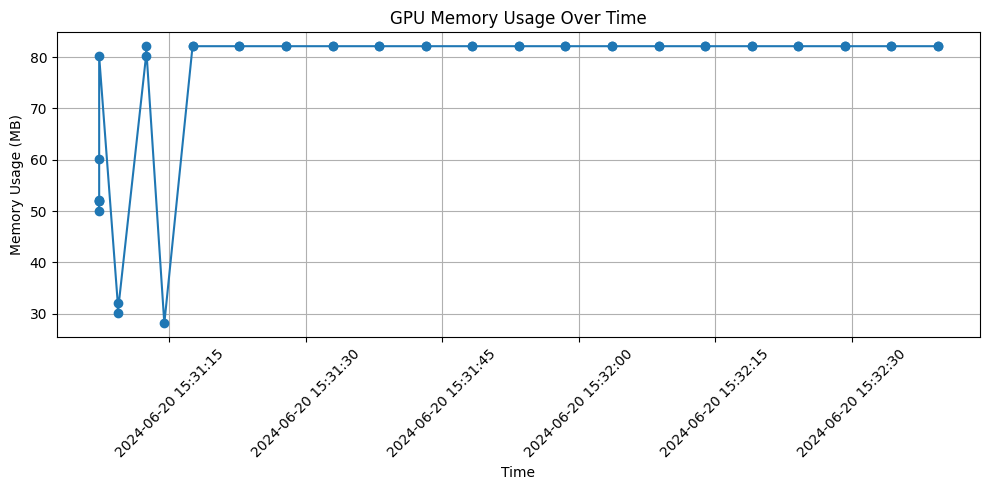

KeyboardInterrupt: 

In [29]:
import json
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import subprocess
import matplotlib.dates as mdates
import time


# 读取系统启动时间
def get_system_start_time():
    result = subprocess.run(["uptime", "-s"], stdout=subprocess.PIPE)
    start_time_str = result.stdout.decode().strip()
    start_time = datetime.strptime(start_time_str, "%Y-%m-%d %H:%M:%S")
    return start_time


# 读取日志文件
def read_log_file(file_path):
    with open(file_path, "r") as file:
        lines = file.readlines()
    return lines


# 解析日志数据
def parse_log_line(line):
    parts = line.strip().split(", ")
    data = {}
    for part in parts:
        key_value = part.split(": ")
        if len(key_value) == 2:
            key, value = key_value
            if key in ["pid", "tid", "size", "ByteCount"]:
                data[key] = int(value)
            elif key in ["time_start", "time_end"]:
                data[key] = int(value)
            elif key in ["devPtr", "dstDevice", "srcDevice", "srcHost", "dstHost", "hStream", "f", "kernelParams", "extra"]:
                data[key] = int(value, 16)
    return data


# 将ebpf时间戳转换为实际时间
def convert_to_actual_time(timestamp_ns, system_start_time):
    timestamp_s = timestamp_ns / 1e9
    actual_time = system_start_time + timedelta(seconds=timestamp_s)
    return actual_time


# 解析日志文件并提取cuMemAlloc_v2和cuMemFree_v2事件
def extract_memory_events(file_path, system_start_time):
    lines = read_log_file(file_path)
    alloc_events = []
    free_events = []
    prefix_to_name = {
        "[cuMemAlloc_v2]": "cuMemAlloc_v2",
        "[cuMemFree_v2]": "cuMemFree_v2",
    }

    for line in lines:
        content = line.split(" - ", 1)[1].strip()
        for prefix, name in prefix_to_name.items():
            if content.startswith(prefix):
                data = parse_log_line(content[len(prefix):].strip())
                data["log_time"] = convert_to_actual_time(data["time_start"], system_start_time)
                if name == "cuMemAlloc_v2":
                    alloc_events.append(data)
                elif name == "cuMemFree_v2":
                    free_events.append(data)
                break  # 找到匹配前缀后跳出循环，继续处理下一行

    return alloc_events, free_events


# 生成显存使用随时间变化的图
def plot_memory_usage(alloc_events, free_events, system_start_time):
    events = alloc_events + free_events
    events.sort(key=lambda e: e["time_start"])

    time_points = []
    memory_usage = []
    memory_map = {}

    for event in events:
        time_points.append(event["log_time"])
        if "size" in event:  # Alloc event
            memory_map[event["devPtr"]] = event["size"]
        else:  # Free event
            if event["devPtr"] in memory_map:
                memory_map.pop(event["devPtr"])
        memory_usage.append(sum(memory_map.values()) / (1024 * 1024))  # 转换为MB

    # 清除之前的图形
    plt.clf()

    # 绘制图形
    plt.figure(figsize=(10, 5))
    plt.plot(time_points, memory_usage, marker="o")
    plt.xlabel("Time")
    plt.ylabel("Memory Usage (MB)")
    plt.title("GPU Memory Usage Over Time")
    plt.grid(True)
    # 设置日期格式
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M:%S"))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())

    plt.xticks(rotation=45)
    plt.tight_layout()  # 自动调整布局
    plt.savefig("trace_mem.png")
    plt.show()
    plt.close()

# 定期刷新绘图
def refresh_plot(interval, input_path, system_start_time):
    while True:
        alloc_events, free_events = extract_memory_events(input_path, system_start_time)
        plot_memory_usage(alloc_events, free_events, system_start_time)
        time.sleep(interval)


# 输入路径
input_path = "logfile.txt"

# 获取系统启动时间
system_start_time = get_system_start_time()

# 定期刷新间隔（秒）
interval = 5  # 每5秒刷新一次

# 开始定期刷新绘图
refresh_plot(interval, input_path, system_start_time)


In [ ]:
# 输入文本
text = """
           <...>-1803353 [000] d... 1323220.392464: bpf_trace_printk: cudaMallocExited success. devPtr:00000000f76543cf, size:2097152
           <...>-1803353 [000] d... 1323220.392469: bpf_trace_printk: cudaMallocExited success. time_start:1323230183319363, time_end:1323230184131020
           <...>-1803353 [000] d... 1323220.392601: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:00000000f76543cf, src:0000000078d58fbb, size:4
           <...>-1803353 [000] d... 1323220.392605: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323230184231723, time_end:1323230184272540
           <...>-1803353 [000] d... 1323220.392627: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
           <...>-1803353 [000] d... 1323220.392628: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323230184283124, time_end:1323230184299437
           <...>-1803353 [000] d... 1323220.392859: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:000000008818efc1, src:00000000c5e81ee2, size:4
           <...>-1803353 [000] d... 1323220.392862: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323230184515344, time_end:1323230184531281
           <...>-1803353 [000] d... 1323220.392875: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
           <...>-1803353 [000] d... 1323220.392877: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323230184539247, time_end:1323230184548136
         python3-1803353 [003] d... 1323222.043123: bpf_trace_printk: cudaMallocExited success. devPtr:00000000e06ba31e, size:20971520
         python3-1803353 [003] d... 1323222.043128: bpf_trace_printk: cudaMallocExited success. time_start:1323231834262090, time_end:1323231834802800
         python3-1803353 [003] d... 1323222.057726: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:00000000e06ba31e, src:00000000bc8ec19d, size:4000000
         python3-1803353 [003] d... 1323222.057730: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231834885538, time_end:1323231849406589
         python3-1803353 [003] d... 1323222.057779: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
         python3-1803353 [003] d... 1323222.057782: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231849426859, time_end:1323231849464732
         python3-1803353 [003] d... 1323222.090509: bpf_trace_printk: cudaLaunchKernelExited success. func:000000005ee8ebaf, stream:1363497824
         python3-1803353 [003] d... 1323222.090514: bpf_trace_printk: cudaLaunchKernelExited success. time_start:1323231850086341, time_end:1323231882190427
         python3-1803353 [003] d... 1323222.129347: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:00000000b8d7bb5a, src:00000000e06ba31e, size:4000000
         python3-1803353 [003] d... 1323222.129354: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231916946655, time_end:1323231921028562
         python3-1803353 [003] d... 1323222.129389: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
         python3-1803353 [003] d... 1323222.129390: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231921050557, time_end:1323231921074653
         python3-1803353 [003] d... 1323222.133554: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:0000000031cfbdf0, src:00000000c3835d8a, size:4000000
         python3-1803353 [003] d... 1323222.133559: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231921207093, time_end:1323231925236335
         python3-1803353 [003] d... 1323222.133590: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
         python3-1803353 [003] d... 1323222.133593: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925254289, time_end:1323231925276318
         python3-1803353 [003] d... 1323222.133861: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:00000000582ba024, src:00000000f76543cf, size:4
         python3-1803353 [003] d... 1323222.133863: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231925507469, time_end:1323231925545748
         python3-1803353 [003] d... 1323222.133876: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
         python3-1803353 [003] d... 1323222.133877: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925553155, time_end:1323231925561806
         python3-1803353 [003] d... 1323222.133954: bpf_trace_printk: cudaMemcpyAsyncExited success. dst:000000000ef6aaec, src:000000008818efc1, size:4
         python3-1803353 [003] d... 1323222.133956: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231925619350, time_end:1323231925639629
         python3-1803353 [003] d... 1323222.133965: bpf_trace_printk: cudaStreamSynchronizeExited success. stream:0
         python3-1803353 [003] d... 1323222.133967: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925645720, time_end:1323231925651347
         python3-1803353 [003] d... 1323222.138057: bpf_trace_printk: cudaFreeExited success. devPtr:00000000f76543cf
         python3-1803353 [003] d... 1323222.138061: bpf_trace_printk: cudaFreeExited success.time_start:1323231925705548, time_end:1323231929739768
"""

# 提取带有 time_start 的行和不带的行
lines_with_time_start = []
lines_without_time_start = []

for line in text.split('\n'):
    if 'time_start' in line:
        lines_with_time_start.append(line)
    else:
        lines_without_time_start.append(line)

# 打印带有 time_start 的行，并提取时间戳
print("Lines with time_start:")
for line in lines_with_time_start:
    print(line)

# 打印不带 time_start 的行
print("\nLines without time_start:")
for line in lines_without_time_start:
    print(line)


In [ ]:
timestamps = [
    ("cudaMalloc", 1302070935381044, 1302070935677717),
    ("cudaMemcpyAsync", 1302070935770011, 1302070935808729),
    ("cudaStreamSynchronize", 1302070935817920, 1302070935829155),
    ("cudaMemcpyAsync", 1302070936034369, 1302070936045026),
    ("cudaStreamSynchronize", 1302070936051694, 1302070936057275),
    ("cudaMalloc", 1302072510599757, 1302072510893090),
    ("cudaMemcpyAsync", 1302072510951702, 1302072511806472),
    ("cudaStreamSynchronize", 1302072511818535, 1302072511883611),
    ("cudaLaunchKernel", 1302072512426785, 1302072527932650),
    ("cudaMemcpyAsync", 1302072559309040, 1302072563673060),
    ("cudaStreamSynchronize", 1302072563695342, 1302072563713245),
    ("cudaMemcpyAsync", 1302072563908108, 1302072563935550),
    ("cudaStreamSynchronize", 1302072563944544, 1302072563951323),
    ("cudaMemcpyAsync", 1302072564013322, 1302072564030123),
    ("cudaStreamSynchronize", 1302072564037029, 1302072564042937),
    ("cudaFree", 1302072564088023, 1302072606595799),
    ("cudaMemcpyAsync", 1302072606712258, 1302072606741939),
    ("cudaStreamSynchronize", 1302072606748991, 1302072606755671),
    ("cudaMemcpyAsync", 1302072606870610, 1302072611938782),
    ("cudaStreamSynchronize", 1302072611949631, 1302072611960515),
]

# 计算并打印每个时间段的持续时间
print("持续时间：")
for api, start, end in timestamps:
    duration = end - start
    print(f"{api}: {duration} 纳秒")


In [ ]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


def convert_timestamp(timestamp_ns):
    # 系统启动后的时间，单位秒
    uptime_seconds = float(open("/proc/uptime").read().split()[0])

    # 系统当前时间
    current_time = datetime.now()

    # 系统启动时间
    boot_time = current_time - timedelta(seconds=uptime_seconds)

    # 将纳秒转换为秒
    seconds_since_boot = timestamp_ns / 1e9

    # 计算事件的实际时间
    event_time = boot_time + timedelta(seconds=seconds_since_boot)

    return event_time


timestamps = [
    ("cudaMalloc", 1323230183319363, 1323230184131020),
    ("cudaMemcpyAsync", 1323230184231723, 1323230184272540),
    ("cudaMemcpyAsync", 1323230184515344, 1323230184531281),
    ("cudaMalloc", 1323231834262090, 1323231834802800),
    ("cudaMemcpyAsync", 1323231834885538, 1323231849406589),
    ("cudaLaunchKernel", 1323231850086341, 1323231882190427),
    ("cudaMemcpyAsync", 1323231916946655, 1323231921028562),
    ("cudaMemcpyAsync", 1323231921207093, 1323231925236335),
    ("cudaMemcpyAsync", 1323231925507469, 1323231925545748),
    ("cudaMemcpyAsync", 1323231925619350, 1323231925639629),
    ("cudaFree", 1323231925705548, 1323231929739768),
]
# 提取时间戳和 API 名称
api_names = [ts[0] for ts in timestamps]
start_times = [ts[1] for ts in timestamps]
end_times = [ts[2] for ts in timestamps]

# 转换时间戳为 datetime 对象
start_datetimes = [convert_timestamp(ts) for ts in start_times]
end_datetimes = [convert_timestamp(ts) for ts in end_times]

# 定义颜色映射字典
color_map = {"cudaMalloc": "blue", "cudaMemcpyAsync": "green", "cudaStreamSynchronize": "red", "cudaLaunchKernel": "orange", "cudaFree": "purple"}

# 画图
plt.figure(figsize=(12, 6))
for i, (start, end) in enumerate(zip(start_datetimes, end_datetimes)):
    api_name = api_names[i]
    plt.plot([start, end], [i, i], marker="o", markersize=6, color=color_map[api_name], label=api_name)
    # 标注时间间隔
    interval_text = f"{(end - start).total_seconds()*1e3:.3f} ms"
    plt.text(start, i, f"Start: {start.strftime('%H:%M:%S.%f')}   {interval_text}", ha="left", va="bottom", fontsize=8, color="black")
    # plt.text(start + (end - start) / 2, i, f"{interval_text}", ha="center", va="bottom", fontsize=8, color="black")

# 设置图表属性
plt.xlabel("Time")
plt.yticks(range(len(timestamps)), api_names)
plt.ylabel("API Name")
plt.title("Timeline of CUDA API Calls")
plt.grid(True)
plt.tight_layout()
# plt.legend(loc='upper left')  # 添加图例
plt.show()


In [ ]:
import re

# 假设文本1的内容存储在一个字符串变量 text1 中
text1 = """
           <...>-1803353 [000] d... 1323220.392469: bpf_trace_printk: cudaMallocExited success. time_start:1323230183319363, time_end:1323230184131020
           <...>-1803353 [000] d... 1323220.392605: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323230184231723, time_end:1323230184272540
           <...>-1803353 [000] d... 1323220.392628: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323230184283124, time_end:1323230184299437
           <...>-1803353 [000] d... 1323220.392862: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323230184515344, time_end:1323230184531281
           <...>-1803353 [000] d... 1323220.392877: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323230184539247, time_end:1323230184548136
         python3-1803353 [003] d... 1323222.043128: bpf_trace_printk: cudaMallocExited success. time_start:1323231834262090, time_end:1323231834802800
         python3-1803353 [003] d... 1323222.057730: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231834885538, time_end:1323231849406589
         python3-1803353 [003] d... 1323222.057782: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231849426859, time_end:1323231849464732
         python3-1803353 [003] d... 1323222.090514: bpf_trace_printk: cudaLaunchKernelExited success. time_start:1323231850086341, time_end:1323231882190427
         python3-1803353 [003] d... 1323222.129354: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231916946655, time_end:1323231921028562
         python3-1803353 [003] d... 1323222.129390: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231921050557, time_end:1323231921074653
         python3-1803353 [003] d... 1323222.133559: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231921207093, time_end:1323231925236335
         python3-1803353 [003] d... 1323222.133593: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925254289, time_end:1323231925276318
         python3-1803353 [003] d... 1323222.133863: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231925507469, time_end:1323231925545748
         python3-1803353 [003] d... 1323222.133877: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925553155, time_end:1323231925561806
         python3-1803353 [003] d... 1323222.133956: bpf_trace_printk: cudaMemcpyAsyncExited success. time_start:1323231925619350, time_end:1323231925639629
         python3-1803353 [003] d... 1323222.133967: bpf_trace_printk: cudaStreamSynchronizeExited success. time_start:1323231925645720, time_end:1323231925651347
         python3-1803353 [003] d... 1323222.138061: bpf_trace_printk: cudaFreeExited success. time_start:1323231925705548, time_end:1323231929739768
         """

# 使用正则表达式解析文本
pattern = r": bpf_trace_printk: (\w+) success\. time_start:(\d+), time_end:(\d+)"
matches = re.findall(pattern, text1)

# 转换时间戳并准备格式化输出
timestamps = []
for match in matches:
    api_name = match[0].replace("Exited", "")
    time_start = int(match[1])
    time_end = int(match[2])
    timestamps.append((api_name, time_start, time_end))

# 格式化输出
formatted_output = "timestamps = [\n"
for name, start, end in timestamps:
    formatted_output += f'    ("{name}", {start}, {end}),\n'
formatted_output += "]"

print(formatted_output)


In [ ]:
import re

# 定义要匹配的文本
text = """
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cuda_runtime/lib/libcudart.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/libtorch_cuda.so", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/libc10_cuda.so", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cudnn/lib/libcudnn.so.8", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cuda_cupti/lib/libcupti.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cusparse/lib/libcusparse.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cufft/lib/libcufft.so.11", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/libcusparseLt-f8b4a9fb.so.0", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/curand/lib/libcurand.so.10", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cublas/lib/libcublas.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/root/miniconda3/envs/tangou101/lib/python3.10/site-packages/torch/lib/../../nvidia/cublas/lib/libcublasLt.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/usr/local/cuda-12.2/lib64/libnvJitLink.so.12", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/lib64/libcuda.so.1", O_RDONLY|O_CLOEXEC) = 3
openat(AT_FDCWD, "/usr/local/cuda-12.2/lib64/libnvrtc.so", O_RDONLY|O_CLOEXEC) = 3
"""

# 使用正则表达式匹配路径
paths = re.findall(r'"/[^"]+"', text)

# 打印提取出的路径
for path in paths:
    print(path+",")

In [ ]:
log_text="""
          python-156144  [007] d... 1173480.908678: bpf_trace_printk: cuCtxGetDeviceEntry
          python-156144  [007] d... 1173480.908711: bpf_trace_printk: cuCtxGetDeviceEntry
          python-156144  [007] d... 1173480.908721: bpf_trace_printk: cuCtxGetDeviceEntry
          python-156144  [007] d... 1173480.908759: bpf_trace_printk: cuStreamSynchronizeEntry
          python-156144  [007] d... 1173480.908779: bpf_trace_printk: cuDevicePrimaryCtxGetStateEntry
          python-156144  [007] d... 1173480.908787: bpf_trace_printk: cuCtxGetDeviceEntry
"""
# 使用正则表达式匹配 cuxxxx 函数名
unique_cu_functions = set(re.findall(r'cu\w+(?=Entry)', log_text))

# 打印去重后的函数名
for func in unique_cu_functions:
    print(func)